И самое последнее -  я хочу объединить две модели в одну. Первая модель будет получать на вход признаки из CountVectorizer, вторая модель - признаки, которые я выделила сама (количество символов, цифр, латиницы и т.п.) Потом они объединятся и выдадут совместный результат.

Я пользовалась вот этим тьюториалом:

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

In [0]:
!pip install emoji

In [0]:
import numpy as np
import pandas as pd
from nltk.tokenize import wordpunct_tokenize
import emoji


In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython.display import Image

from keras.utils import plot_model

Using TensorFlow backend.


In [0]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [0]:
import keras
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from keras.layers import Dense,Activation,Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model



In [5]:
# загружаю датасет
df_features = pd.read_csv('gk4z_features.csv')
df_features.head()

,id,text,likes,label,len_char,punct,punct_count,punct%,tokens,tokens_count,tokens%,smiles,smiles_count,smiles%,numbers_count,numbers%,latin_count,latin%
0,76000,#конкурс@the4gkz \r\r\r\nДля вашего удобства с...,17,post,503,"#@.:•|-.—:./:./•|-.—/:./:://./|://./•|.—:./:.,!",47,0.093439,"['#', 'конкурс', '@', 'the4gkz', 'Для', 'вашег...",81,0.161034,NaN,0,0.000000,23,0.045726,116,0.230616
1,76914,Уже сегодня ночью (по МСК) начнётся один из са...,34,post,669,"()—.—()!..,!(),—(,).:://..//",28,0.041854,"['Уже', 'сегодня', 'ночью', '(', 'по', 'МСК', ...",111,0.165919,NaN,0,0.000000,0,0.000000,49,0.073244
2,76917,"Ого, Нина Кравиц в лайн-апе😲",0,comment,28,",-",2,0.071429,"['Ого', ',', 'Нина', 'Кравиц', 'в', 'лайн-апе😲']",6,0.214286,😲,1,0.035714,0,0.000000,0,0.000000
3,76920,"[id17823823|Анастасия], с новым крутым шоу от ...",0,comment_to_comment,56,"[|],",4,0.071429,"['[', 'id17823823|Анастасия', ']', ',', 'с', '...",11,0.196429,NaN,0,0.000000,8,0.142857,2,0.035714
4,76922,Скину расписание на сегодня сюда. Время москов...,0,comment,687,..:......&....:..........:......&.....,38,0.055313,"['Скину', 'расписание', 'на', 'сегодня', 'сюда...",112,0.163028,NaN,0,0.000000,127,0.184862,332,0.483261


In [0]:
# функция, которая меняет лейблы на цифры
def mapping(data,feature):
    featureMap=dict()
    count=0
    for i in sorted(data[feature].unique(),reverse=True):
        featureMap[i]=count
        count=count+1
    data[feature]=data[feature].map(featureMap)
    return data

In [0]:
# рисует функцию потерь в процессе выполнения
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [0]:
#меняем лейблы
df_features=mapping(df_features,feature="label")

In [0]:
#делим датасет на тренировочный и тестовый
x_train, x_test, y_train, y_test = train_test_split(df_features, df_features.label)

## Первая ветка

In [10]:
#делаем признаки КаунтВекторайзером
vectorizer = CountVectorizer(tokenizer=wordpunct_tokenize) 
vectorizer.fit(df_features.text)

X_train = vectorizer.transform(x_train.text)
X_test  = vectorizer.transform(x_test.text)
X_train

<38877x68660 sparse matrix of type '<class 'numpy.int64'>'
	with 504606 stored elements in Compressed Sparse Row format>

In [11]:
input_dim1 = X_train.shape[1]
input_dim1

68660

In [12]:
# Делаем модель для первой ветки
model1=Sequential()
model1.add(Dense(10,input_dim=input_dim1, activation="relu"))
model1.add(Dense(10, activation="relu"))


Instructions for updating:
Colocations handled automatically by placer.


## Вторая ветка

In [0]:
# делаем датасет с признаками для второй ветки
X_train2 =x_train.drop(["label", 'text', 'id', "punct","smiles","tokens"],axis=1)
X_test2 = x_test.drop(["label", 'text', 'id', "punct","smiles","tokens"],axis=1)


In [15]:
input_dim2 = X_train2.shape[1]
input_dim2

12

In [0]:
# Делаем модель для второй ветки
model2=Sequential()
model2.add(Dense(10, input_dim=input_dim2, activation="relu"))


## Объединяем ветки

In [0]:
# соединяем результаты обеих веток
combinedInput = concatenate([model1.output, model2.output])

In [0]:
# прогоняем их еще через два слоя
x = Dense(3, activation="relu")(combinedInput)
x = Dense(3, activation=tf.nn.softmax)(x)

In [0]:
# записываем всё в единую модель
combined_model = Model(inputs=[model1.input, model2.input], outputs=x)

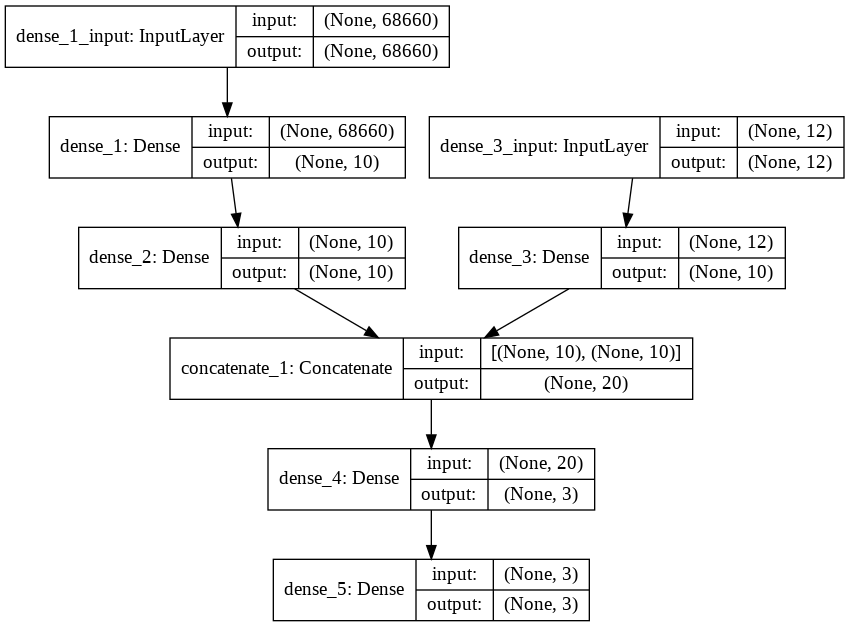

In [20]:
# посмотрим, как оно всё выглядит

plot_model(combined_model, to_file="test_keras_plot_model.png", show_shapes=True)
Image("test_keras_plot_model.png")

In [0]:
# компилируем объединенную модель
combined_model.compile(loss="sparse_categorical_crossentropy",optimizer='rmsprop',metrics=['sparse_categorical_accuracy'])

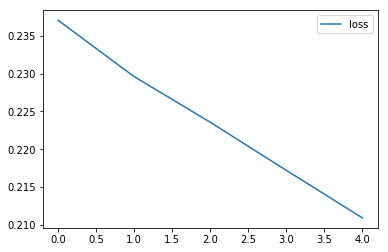

In [56]:
# запускаем обучение
history = combined_model.fit([X_train,X_train2],y_train, class_weight= {0:1.27977484, 1:3.8534047, 2:0.510438},epochs=5, callbacks=[plot_losses] )

In [0]:
def classif_report(current_model):
    predY=current_model.predict([X_test, X_test2]) 
    new_ar = []
    for el in predY:
        new_ar.append(np.argmax(el))
    print(classification_report(y_test, new_ar))
  

Я попробовала разные варианты (все ниже), но лучший результат у меня получился со следующими настройками:


*   word_punct tokenizer в КаунтВекторайзере

*   два слоя по 10 нейронов в первой ветке

*   один слой с 10 нейронами во второй ветке
*   два слоя по 3 нейрона в общей ветке


*   веса, которые выдал sklearn {0:1.27977484, 1:3.8534047, 2:0.510438}
*   10-15 эпох (на 20 эпохах получилось переобучение)

С этими настройками, как мне кажется, комменты второго уровня определяются лучше всего с минимальным ущербом для остальных классов.








In [55]:
classif_report(combined_model)
# word_punct tokenizer
# веса сбаланс, 
# ветвь 1 - 10,10
# ветвь 2 - 10
# общая ветвь -  3,3
# эпох 15

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3352
           1       0.46      0.73      0.56      1131
           2       0.95      0.87      0.91      8476

   micro avg       0.88      0.88      0.88     12959
   macro avg       0.79      0.86      0.81     12959
weighted avg       0.91      0.88      0.89     12959



In [58]:
classif_report(combined_model)
# word_punct tokenizer
# веса сбаланс, 
# ветвь 1 - 10,10
# ветвь 2 - 10
# общая ветвь -  3,3
# эпох 20 - переобучение, результат похуже.

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3352
           1       0.39      0.77      0.52      1131
           2       0.95      0.82      0.88      8476

   micro avg       0.85      0.85      0.85     12959
   macro avg       0.76      0.85      0.79     12959
weighted avg       0.90      0.85      0.87     12959



In [53]:
classif_report(combined_model)
# word_punct tokenizer
# веса сбаланс, 
# ветвь 1 - 10,10
# ветвь 2 - 10
# общая ветвь -  3,3
# эпох 10

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3352
           1       0.43      0.79      0.55      1131
           2       0.96      0.84      0.89      8476

   micro avg       0.87      0.87      0.87     12959
   macro avg       0.78      0.87      0.80     12959
weighted avg       0.91      0.87      0.88     12959



In [51]:
classif_report(combined_model)
# word_punct tokenizer
# веса сбаланс, 
# ветвь 1 - 10,10
# ветвь 2 - 10
# общая ветвь -  3,3
# эпох 5

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3352
           1       0.36      0.83      0.50      1131
           2       0.96      0.78      0.86      8476

   micro avg       0.84      0.84      0.84     12959
   macro avg       0.76      0.86      0.77     12959
weighted avg       0.90      0.84      0.86     12959



analyzer="char", ngram_range=(2,2)

In [29]:
classif_report(combined_model)
#analyzer="char", ngram_range=(2,2)
# веса сбаланс, 
# ветвь 1 - 10,
# ветвь 2 - 10
# общая ветвь -  3
# эпох 10

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3381
           1       0.42      0.66      0.51      1156
           2       0.94      0.86      0.90      8422

   micro avg       0.87      0.87      0.87     12959
   macro avg       0.77      0.83      0.79     12959
weighted avg       0.90      0.87      0.88     12959



In [27]:
classif_report(combined_model)
#analyzer="char", ngram_range=(2,2)
# веса сбаланс, 
# ветвь 1 - 10,
# ветвь 2 - 10
# общая ветвь -  3
# эпох 5

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3381
           1       0.42      0.71      0.53      1156
           2       0.94      0.86      0.90      8422

   micro avg       0.87      0.87      0.87     12959
   macro avg       0.78      0.84      0.80     12959
weighted avg       0.90      0.87      0.88     12959



In [0]:
def classif_report(current_model):
    predY=current_model.predict([X_test, X_test2]) 
    new_ar = []
    for el in predY:
        new_ar.append(np.argmax(el))
    print(classification_report(y_test, new_ar))
  

In [24]:
classif_report(combined_model)
#analyzer="char", ngram_range=(2,2)
# нет весов, 
# ветвь 1 - 10,
# ветвь 2 - 10
# общая ветвь -  3
# эпох 10

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3381
           1       0.60      0.26      0.36      1156
           2       0.89      0.97      0.93      8422

   micro avg       0.90      0.90      0.90     12959
   macro avg       0.82      0.73      0.75     12959
weighted avg       0.89      0.90      0.89     12959



In [24]:
classif_report(combined_model)
#analyzer="char", ngram_range=(2,2)
# нет весов, 
# ветвь 1 - 50,50
# ветвь 2 - 10
# общая ветвь -  3
# эпох 10

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3347
           1       0.56      0.29      0.39      1101
           2       0.90      0.96      0.93      8511

   micro avg       0.90      0.90      0.90     12959
   macro avg       0.81      0.74      0.76     12959
weighted avg       0.89      0.90      0.89     12959



In [23]:
classif_report(combined_model)
#analyzer="char", ngram_range=(2,2)
# нет весов, 
# ветвь 1 - 50,50
# ветвь 2 - 50
# общая ветвь -  3
# эпох 5

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3416
           1       0.59      0.31      0.40      1123
           2       0.90      0.96      0.93      8420

   micro avg       0.90      0.90      0.90     12959
   macro avg       0.82      0.74      0.76     12959
weighted avg       0.89      0.90      0.89     12959



In [24]:
classif_report(combined_model)
#analyzer="char", ngram_range=(2,2)
# нет весов, 
# ветвь 1 - 50,50
# ветвь 2 - 50
# общая ветвь - 50, 3
# эпох 5

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3453
           1       0.56      0.30      0.39      1093
           2       0.90      0.96      0.93      8413

   micro avg       0.91      0.91      0.91     12959
   macro avg       0.81      0.74      0.76     12959
weighted avg       0.89      0.91      0.90     12959

